In [1]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import tensorflow.keras as keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, UpSampling2D, Flatten, BatchNormalization, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import cifar100
import tensorflow as tf
from keras.utils import np_utils
import numpy as np
import matplotlib.pyplot as plt
import time
from skimage.transform import resize
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator

In [2]:
num_classes = 100

(x_train, y_train), (x_test, y_test) = cifar100.load_data()

In [3]:
x_val = x_train[40000:50000, ]
x_train = x_train[:40000, ]
y_val = y_train[40000:50000]
y_train = y_train[:40000]
print(x_train.shape, y_train.shape)

(40000, 32, 32, 3) (40000, 1)


In [4]:
import cv2
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for keras'
    def __init__(self, images , labels = None,  batch_size = 64,
                 dim = (224, 224), n_classes = 100,
                 shuffle = True):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.dim = dim
        self.n_classes = n_classes
        self.shuffle = shuffle
        
        self.indexes = np.arange(self.images.shape[0]) # (0,1,2,3,...,40000)

        self.on_epoch_end()
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        
        if self.shuffle == True:
            np.random.shuffle(self.indexes) 
            
    def __len__(self):
        'Denotes the number of batches per epoch'
        return self.images.shape[0] // self.batch_size 
        
    def __getitem__(self, index):
        'Generate batch of data in position index'
        # index * batch_size : (index +1) *batch_size

        batch_indexes = self.indexes[ index*self.batch_size:(index+1)*self.batch_size]
        
        images =[]
        labels =[] 

        for i in batch_indexes:

          img_i = self.images[i] 
          img_i = cv2.resize(img_i , self.dim )
          img_i = (img_i) / 127. - 1 

          # augm.... 
          images.append(img_i)

          label_i = self.labels[i]
          labels.append(label_i)
      
        images = np.stack(images) # batch_size, 224,224,3
        labels = np_utils.to_categorical(labels, self.n_classes)

        return images, labels 

In [5]:
resnet_model = ResNet50(weights='imagenet', include_top=False,
                        input_shape=(224,224,3))
avg = GlobalAveragePooling2D()(resnet_model.output)

den1 = Dense(512, activation='relu')(avg)
bn = BatchNormalization()(den1)

drop1 = Dropout(0.4)(bn)
den2 = Dense(num_classes, activation='softmax')(drop1)

model = tf.keras.Model(inputs = resnet_model.inputs, outputs =[den2])


In [6]:
for layer in resnet_model.layers:
  if isinstance(layer, BatchNormalization):
    layer.trainable = True
  else:
    layer.trainable = False
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [7]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
bs = 16
data_gen = DataGenerator(
    x_train,
    y_train,
    batch_size = bs,
    dim = (224, 224), n_classes = 100,
    shuffle = True
)
val_gen  = DataGenerator(
    x_val,
    y_val,
    batch_size = bs,
    dim = (224, 224), n_classes = 100,
    shuffle = False
)

Freeze pre-train and warm up top layers

In [8]:
t=time.time()
Epoch = 5
historytemp = model.fit(data_gen,
                        validation_data=val_gen,
                        epochs=Epoch)
print('Training time: %s' % (time.time() - t))

Epoch 1/5
2500/2500 [==============================] - 617s 244ms/step - loss: 1.8004 - accuracy: 0.5184 - val_loss: 1.0881 - val_accuracy: 0.6855
Epoch 2/5
2500/2500 [==============================] - 609s 244ms/step - loss: 1.1381 - accuracy: 0.6688 - val_loss: 0.9880 - val_accuracy: 0.7144
Epoch 3/5
2500/2500 [==============================] - 614s 245ms/step - loss: 0.9712 - accuracy: 0.7140 - val_loss: 0.8922 - val_accuracy: 0.7462
Epoch 4/5
2500/2500 [==============================] - 614s 246ms/step - loss: 0.8539 - accuracy: 0.7439 - val_loss: 0.8676 - val_accuracy: 0.7528
Epoch 5/5
2500/2500 [==============================] - 606s 242ms/step - loss: 0.7758 - accuracy: 0.7652 - val_loss: 0.8659 - val_accuracy: 0.7571
Training time: 3060.5014979839325


In [9]:
test_gen = DataGenerator(
    x_test,
    y_test,
    batch_size = bs,
    dim = (224, 224), n_classes = 100,
    shuffle = False
)


In [10]:
model.evaluate(test_gen)

625/625 [==============================] - 58s 93ms/step - loss: 0.8393 - accuracy: 0.7605


[0.8392751216888428, 0.7605000138282776]

Unfreeze pre-train model, update entire model

In [11]:
# unfreeze weights
for layer in resnet_model.layers:
    layer.trainable = True

In [12]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3),
              metrics=['accuracy'])

In [13]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor = 'val_loss', mode = 'min',
                   patience = 5, restore_best_weights = True, verbose = 1)

In [14]:
hist = model.fit(data_gen,
                        validation_data=val_gen,
                  epochs=25,
                  callbacks=[es],
                  verbose=1
                  )

Epoch 1/25
2500/2500 [==============================] - 1218s 486ms/step - loss: 0.6419 - accuracy: 0.8018 - val_loss: 0.8004 - val_accuracy: 0.7746
Epoch 2/25
2500/2500 [==============================] - 1347s 539ms/step - loss: 0.4842 - accuracy: 0.8475 - val_loss: 0.7547 - val_accuracy: 0.7864
Epoch 3/25
2500/2500 [==============================] - 1386s 555ms/step - loss: 0.3817 - accuracy: 0.8813 - val_loss: 0.7285 - val_accuracy: 0.7931
Epoch 4/25
2500/2500 [==============================] - 1262s 505ms/step - loss: 0.3143 - accuracy: 0.9039 - val_loss: 0.7383 - val_accuracy: 0.7931
Epoch 5/25
2500/2500 [==============================] - 819s 327ms/step - loss: 0.2611 - accuracy: 0.9209 - val_loss: 0.7308 - val_accuracy: 0.7961
Epoch 6/25
2500/2500 [==============================] - 812s 325ms/step - loss: 0.2185 - accuracy: 0.9373 - val_loss: 0.7327 - val_accuracy: 0.7951
Epoch 7/25
2500/2500 [==============================] - 814s 325ms/step - loss: 0.1832 - accuracy: 0.9495 - 

In [15]:
model.save_weights("./model_dense512_bn_drop04.h5")

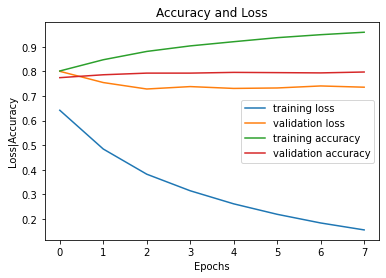

In [16]:
bs = 8
plt.plot(np.arange(0, bs), hist.history['loss'], label='training loss')
plt.plot(np.arange(0, bs), hist.history['val_loss'], label='validation loss')
plt.plot(np.arange(0, bs), hist.history['accuracy'], label='training accuracy')
plt.plot(np.arange(0, bs), hist.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy and Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss|Accuracy')
plt.legend()
plt.show()

In [17]:
model.evaluate(test_gen)

625/625 [==============================] - 58s 93ms/step - loss: 0.7039 - accuracy: 0.7983


[0.7039254307746887, 0.79830002784729]